In [15]:
import torch
import torchvision
import pathlib
from scipy.io import loadmat
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

/home/abey/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [24]:
EDGES = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [6, 7], [7, 8],
         [8, 12], [12, 9], [9, 10], [10, 11], [12, 13], [2, 8], [3, 9]]

In [21]:
@torch.no_grad()
def visualize_sample(image, label, is_heatmap=False):
    image_numpy = (255 * image.cpu().numpy().transpose(1, 2, 0)).astype(np.uint8)

    debug = Image.fromarray(image_numpy)
    draw = ImageDraw.Draw(debug)

    for i, j in EDGES:
        xi = (label[i, 0] / 2.0 + 0.5) * debug.width
        yi = (label[i, 1] / 2.0 + 0.5) * debug.height

        xj = (label[j, 0] / 2.0 + 0.5) * debug.width
        yj = (label[j, 1] / 2.0 + 0.5) * debug.height

        draw.line((xi, yi, xj, yj), fill=(255, 0, 0))

    return np.array(debug)

In [28]:
class ResizeImageAndLabel():
    # size will be the desired resize dimensions as a tuple (height, width)
    def __init__(self, size):
        self.size = size

    def __call__(self, image, label):
        # Labels are normalized from their original pixel coordinates to a range [-1, 1]. These normalized label coordinates
        # will be correct no matter what the resolution of the image is.
        xs = (label[:, 0] / image.width - 0.5) * 2.0
        ys = (label[:, 1] / image.height - 0.5) * 2.0

        image = torchvision.transforms.functional.resize(image, self.size)
        label = np.stack((xs, ys), 1)

        return image, label

In [29]:
class LSPDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, is_train):
        dataset_dir = pathlib.Path(dataset_dir)

        self.transform = ResizeImageAndLabel((128, 128))
        self.to_tensor = torchvision.transforms.ToTensor()

        self.images = list(sorted((dataset_dir / 'images').glob('*.jpg')))
        self.labels = loadmat(str(dataset_dir / 'joints.mat'))['joints'].transpose(2, 1, 0).astype(np.float32)

        split = int(len(self.images) * 0.9)

        if is_train:
            self.images = self.images[:split]
            self.labels = self.labels[:split]
        else:
            self.images = self.images[split:]
            self.labels = self.labels[split:]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):
        image = Image.open(self.images[i])
        label = self.labels[i]

        image, label = self.transform(image, label)
        image = self.to_tensor(image)

        return image, label

In [23]:
def get_data(dataset_dir='.', is_train=True):
    data = LSPDataset(dataset_dir, is_train=is_train)
    dataloader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=is_train, num_workers=2)

    return dataloader

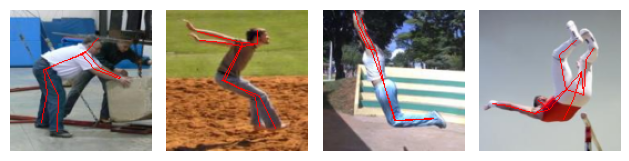

In [31]:
data = LSPDataset(dataset_dir='LeedsSportsPoseDataset', is_train=False)

num_to_show = 4
fig, axes = plt.subplots(nrows=1, ncols=num_to_show)

for i in range(num_to_show):
    image, label = data[i]
    sample = visualize_sample(image, label)

    axes[i].imshow(sample)
    axes[i].axis('off')

plt.tight_layout()
plt.show()